In [51]:
# Import packages
import plotly.express as px
import pandas as pd

# Read in the data
data = pd.read_csv('C:\\Users\\HP\\Documents\\AirPassengerForcasting\\AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])

In [52]:
data.columns

Index(['Month', '#Passengers'], dtype='object')

In [53]:
# data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [54]:
# data secsribe
data.describe()

,Month,#Passengers
count,144,144.000000
mean,1954-12-16 05:00:00,280.298611
min,1949-01-01 00:00:00,104.000000
25%,1951-12-24 06:00:00,180.000000
50%,1954-12-16 12:00:00,265.500000
75%,1957-12-08 18:00:00,360.500000
max,1960-12-01 00:00:00,622.000000
std,NaN,119.966317


In [55]:
data.shape

(144, 2)

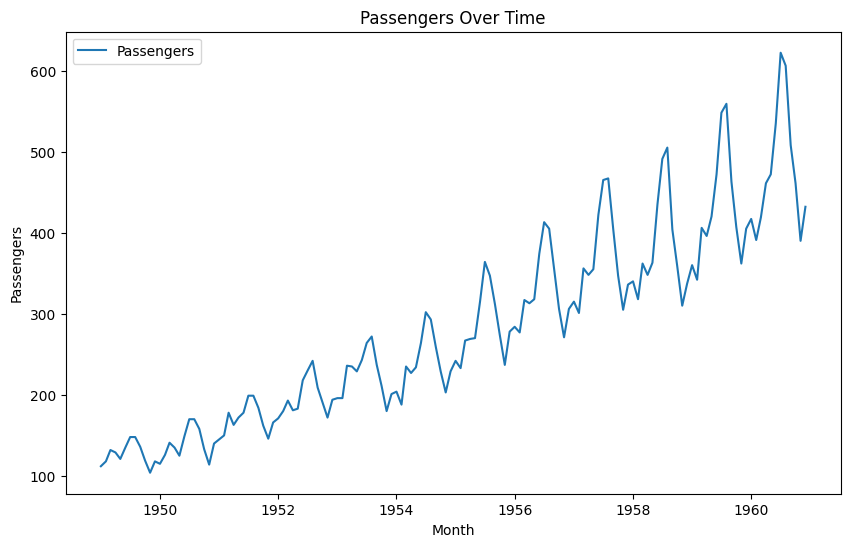

In [56]:
import matplotlib.pyplot as plt

# Plot Passengers over time
plt.figure(figsize=(10,6))
plt.plot(data['Month'], data['#Passengers'], label='Passengers')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.title('Passengers Over Time')
plt.legend()
plt.show()

In [57]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

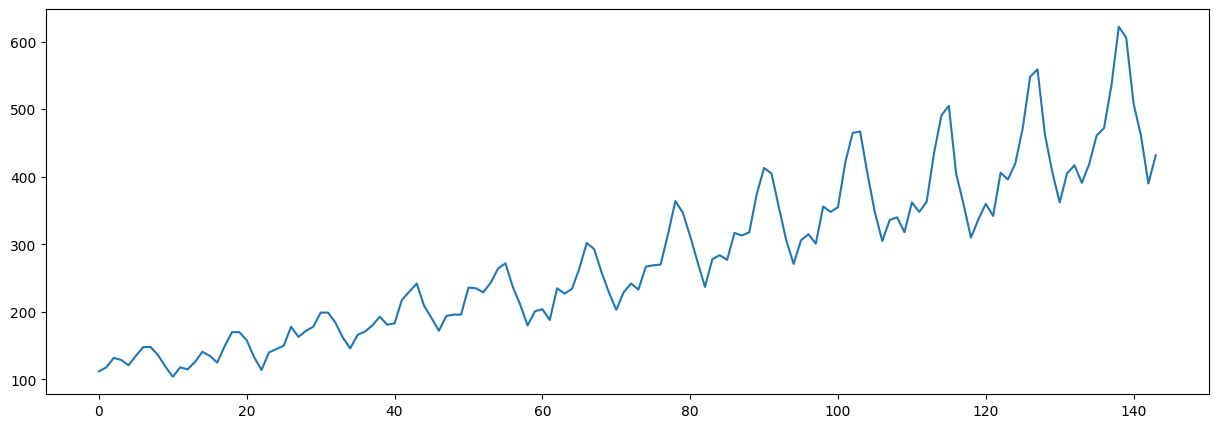

In [58]:
plt.figure(figsize = (15,5))
data['#Passengers'].plot();

From the above graph of Passengers data, we can say that it represents a Multiplicative Model as the data has increasing width & height of the peaks.
Let us decompose the multiple components of the Passengers time series.

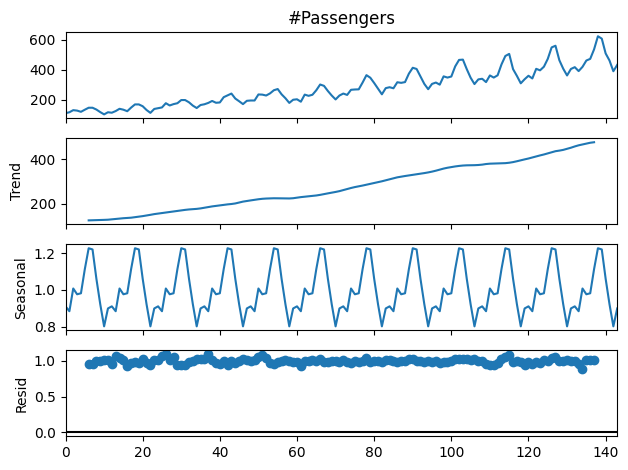

In [59]:
from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
dec = sm.tsa.seasonal_decompose(data['#Passengers'],period = 12, model = 'multiplicative').plot()
plt.show()

Data clearly has a linear uptrend.
A clear cut seasonal pattern of a 1 year duration is present in the data.

Stationarity :
Stationarity is a concept for time series where statistical parameters like mean, variance, etc are all constant over time.<br>
For a time series, features are dependent on time i.e features are a function of time. Statistical paramters will change values over time as they are extracted from the features.<br>
If the time series is not stationary, then the predictions deviate from the original values and increase the error as we don't know the changes in these statistical parameters as they are a function of time.<br>
Thus, by making time series stationary, we kind of nullify the effects of statistical parameters on the forecast.

Checking for stationarity: using Dickey-Fuller Test (ADF Test) and Rolling Statistics.<br>
The Augmented Dickey-Fuller (ADF) test is a statistical test used to check for stationarity.<br>
A low p-value (< 0.05) indicates that the time series is stationary.

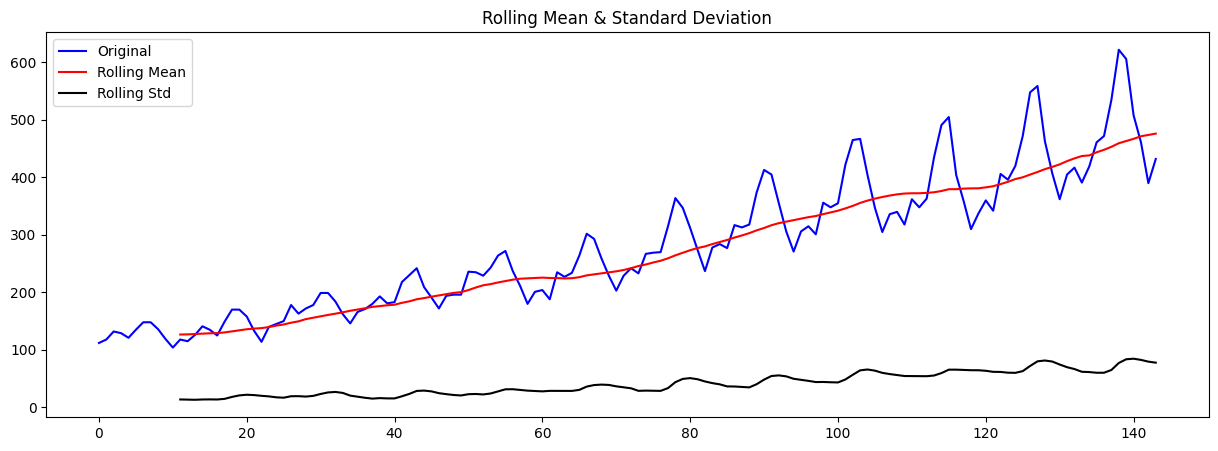

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [60]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(data['#Passengers'])

Fitting the model by instantiating a new Prophet object. Any settings to the forecasting procedure are passed into the constructor. Then you call its fit method and pass in the historical dataframe. Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made.

In [61]:
import pandas as pd
from prophet import Prophet


# Renaming columns to match Prophet's requirements
data.rename(columns={'Month': 'ds', '#Passengers': 'y'}, inplace=True)

# Instantiate Prophet object
m = Prophet()
m.fit(data)

16:29:43 - cmdstanpy - INFO - Chain [1] start processing
16:29:44 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
504,1961-11-27
505,1961-11-28
506,1961-11-29
507,1961-11-30
508,1961-12-01


The predict method will assign each row in future a predicted value which it names yhat. If you pass in historical dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals

In [63]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
504,1961-11-27,498.608511,471.053906,529.606637
505,1961-11-28,497.074770,471.276192,528.095463
506,1961-11-29,494.898299,467.235019,523.457852
507,1961-11-30,492.123197,464.157568,518.620575
508,1961-12-01,488.809057,459.474579,519.366141


C:\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



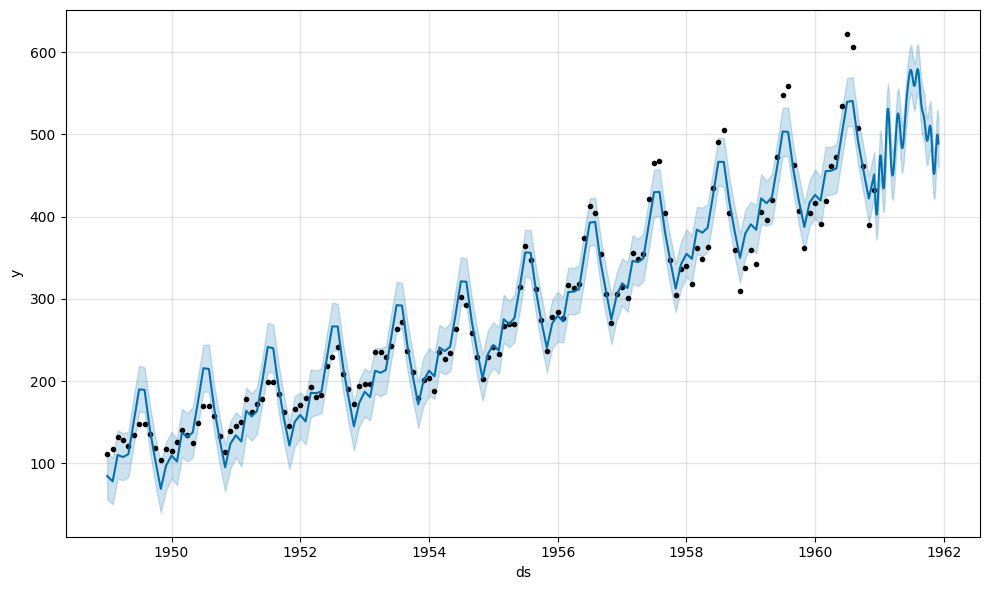

In [64]:
#Plotting the forecast by calling the Prophet.plot method and passing in your forecast dataframe.
fig1 = m.plot(forecast)


If you want to see the forecast components, I used the Prophet.plot_components method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.

C:\Python312\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Python312\Lib\site-packages\prophet\plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Python312\Lib\site-packages\prophet\plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



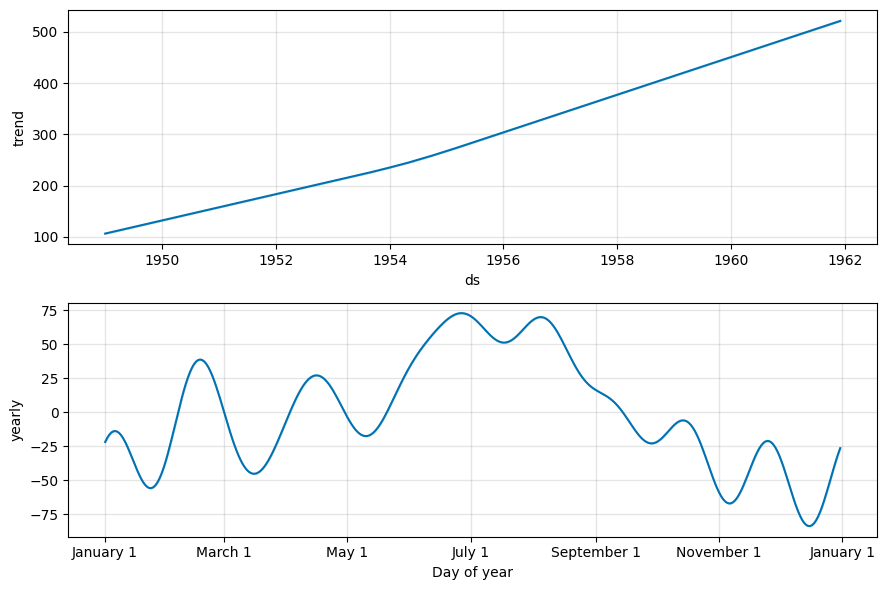

In [65]:
fig2 = m.plot_components(forecast)

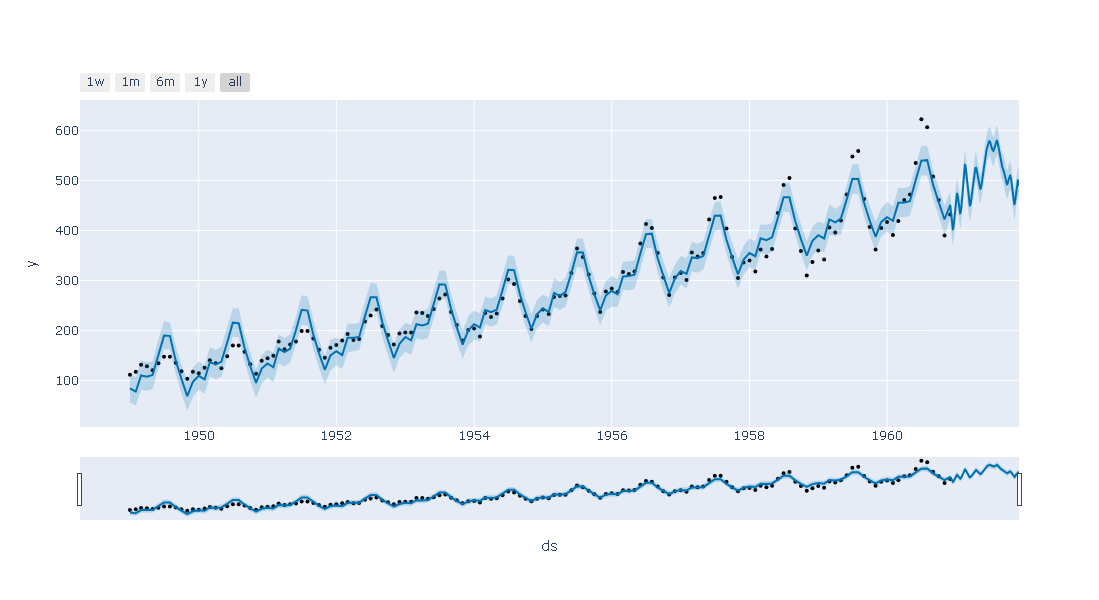

In [66]:
#An interactive figure of the forecast and components created with plotly.
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)